In [43]:
# Cell 1: Import Libraries
import os
import numpy as np
import pretty_midi
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, Layer
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
np.int = int
# Ensure TensorFlow runs on CPU only (if required)
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [44]:
# Cell 2: Preprocessing MIDI Files
def load_and_preprocess_midi(folder_path, max_len=500, input_dim=88):
    """
    Load MIDI files from a folder, preprocess them, and return as a NumPy array.
    """
    midi_data = []

    for file in os.listdir(folder_path):
        if file.endswith(".mid"):
            try:
                midi = pretty_midi.PrettyMIDI(os.path.join(folder_path, file))
                piano_roll = midi.get_piano_roll(fs=100).T[:, :input_dim]  # Restrict to piano keys
                piano_roll = piano_roll / 127.0  # Normalize velocities
                
                # Truncate or pad to fixed length
                if piano_roll.shape[0] > max_len:
                    piano_roll = piano_roll[:max_len, :]
                else:
                    padding = np.zeros((max_len - piano_roll.shape[0], input_dim))
                    piano_roll = np.vstack([piano_roll, padding])
                
                midi_data.append(piano_roll)
            except Exception as e:
                print(f"Failed to process {file}: {e}")
    
    if len(midi_data) == 0:
        raise ValueError("No valid MIDI files found in the directory.")
    
    return np.array(midi_data)

# Preprocess MIDI files
folder_path = os.path.join(os.getcwd(),"midi_files") # Replace with your MIDI folder path
processed_data = load_and_preprocess_midi(folder_path)

# Check the processed data shape
print("Processed Data Shape:", processed_data.shape)
# Shape should be (num_samples, max_len, input_dim), e.g., (100, 500, 88)


Processed Data Shape: (22, 500, 88)


In [45]:
# Custom KL Divergence Loss Layer
class KLDivergenceLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.add_loss(kl_loss)
        return z_mean

In [46]:
# Define MGU-V Model
class MGU_V:
    def __init__(self, input_dim, latent_dim):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.build_model()

    def build_model(self):
        # Encoder
        encoder_inputs = Input(shape=(None, self.input_dim), name="encoder_inputs")
        encoder_lstm = LSTM(64, return_state=True, name="encoder_lstm")
        _, state_h, state_c = encoder_lstm(encoder_inputs)

        # Variational Layer
        z_mean = Dense(self.latent_dim, name="z_mean")(state_h)
        z_log_var = Dense(self.latent_dim, name="z_log_var")(state_h)
        z_mean = KLDivergenceLayer()([z_mean, z_log_var])  # Add KL divergence loss
        z = Lambda(self.sampling, name="z")([z_mean, z_log_var])

        # Map latent vector to decoder LSTM state dimensions
        latent_to_state_h = Dense(64, name="latent_to_state_h")(z)  # Map to hidden state size
        latent_to_state_c = Dense(64, name="latent_to_state_c")(z)  # Map to cell state size

        # Decoder
        decoder_inputs = Input(shape=(None, self.input_dim), name="decoder_inputs")
        decoder_state_input_h = Input(shape=(64,), name="decoder_state_input_h")
        decoder_state_input_c = Input(shape=(64,), name="decoder_state_input_c")
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        decoder_lstm = LSTM(64, return_sequences=True, return_state=True, name="decoder_lstm")
        decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
            decoder_inputs, initial_state=decoder_states_inputs
        )
        decoder_dense = Dense(self.input_dim, activation="softmax", name="decoder_dense")
        decoder_outputs = decoder_dense(decoder_outputs)

        # Define encoder and decoder models
        self.encoder = Model(encoder_inputs, [z_mean, z_log_var, latent_to_state_h, latent_to_state_c], name="encoder")
        self.decoder = Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs, state_h_dec, state_c_dec],
            name="decoder"
        )

        # Variational Autoencoder
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[latent_to_state_h, latent_to_state_c])
        vae_outputs = decoder_dense(decoder_outputs)
        self.vae = Model([encoder_inputs, decoder_inputs], vae_outputs, name="vae")

        # Compile with reconstruction loss
        self.vae.compile(optimizer="adam", loss="categorical_crossentropy")

    def sampling(self, args):
        """Reparameterization trick."""
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], tf.shape(z_mean)[1]))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [47]:
# Data Preparation
def prepare_decoder_inputs(data):
    """
    Prepare decoder inputs by shifting the sequences one step forward.
    """
    shifted_data = np.roll(data, shift=1, axis=1)  # Shift sequences by 1 step
    shifted_data[:, 0, :] = 0  # Zero-out the first step (no information available initially)
    return shifted_data

In [48]:
# Parameters for Training
input_dim = 88  # Restricting to piano keys
latent_dim = 32  # Smaller latent space for simplicity
max_len = 500  # Maximum sequence length
# Validate Data Shape
assert processed_data.ndim == 3, "processed_data must be a 3D array (num_samples, max_len, input_dim)."
assert processed_data.shape[2] == input_dim, "The third dimension of processed_data must match input_dim."

# Prepare Inputs and Outputs
encoder_inputs = processed_data  # Input for the encoder
decoder_inputs = prepare_decoder_inputs(processed_data)  # Shifted version for decoder input
decoder_outputs = processed_data  # Target output

# Check Shapes
assert encoder_inputs.shape == decoder_inputs.shape, "encoder_inputs and decoder_inputs must have the same shape."
assert encoder_inputs.shape == decoder_outputs.shape, "encoder_inputs and decoder_outputs must have the same shape."

# Initialize the model
mgu_v_model = MGU_V(input_dim=input_dim, latent_dim=latent_dim)

# Prepare Data for Training
encoder_inputs = processed_data  # Input for the encoder
decoder_inputs = prepare_decoder_inputs(processed_data)  # Shifted version for decoder input
decoder_outputs = processed_data  # Target output

In [49]:
# Train the Model
mgu_v_model.vae.fit(
    x=[encoder_inputs, decoder_inputs],
    y=decoder_outputs,
    epochs=100,
    batch_size=8
)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 9.6446
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 9.8221
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 9.5004
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 9.1584
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 9.1651
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 8.9682
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 9.1776
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 8.3463
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 8.7213
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 8.3556
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 8.3931
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 8.2207
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 8.4138
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 7.8423
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 7.9690
Epoch 1

In [66]:
def generate_music_with_trained_model(model, latent_dim, input_dim, max_len=500, output_path="generated_music.mid"):
    """
    Generate new music using the trained MGU-V model and save it as a MIDI file.
    """
    # 1. Create a random input sequence
    random_input = np.random.rand(1, 10, input_dim)  # Random values between 0 and 1
    print("Using random values as the initial seed.")

    # 2. Pass the random input through the encoder to get latent states
    encoder_outputs = model.encoder.predict(random_input)  # Get encoder outputs
    state_h, state_c = encoder_outputs[-2], encoder_outputs[-1]  # Extract latent states

    # 3. Start with a random seed for the decoder
    seed_input = np.random.rand(1, 1, input_dim)  # Random values for the first time step
    generated_sequence = []

    # 4. Custom inference loop
    for _ in range(max_len):
        # Predict the next time step
        pred, state_h, state_c = model.decoder.predict([seed_input, state_h, state_c])
        
        # Append the predicted time step to the generated sequence
        generated_sequence.append(pred[:, 0, :])  # Extract the first (and only) time step

        # Update the seed input for the next step
        seed_input = pred[:, -1:, :]  # Shape: (batch_size, time_steps=1, input_dim)

    # Concatenate the generated time steps into a single sequence
    generated_sequence = np.vstack(generated_sequence)  # Shape: (time_steps, input_dim)

    # 5. Convert the generated sequence to MIDI
    def piano_roll_to_midi(piano_roll, output_path):
        """
        Convert a piano roll (generated sequence) to MIDI and save it.
        """
        midi = pretty_midi.PrettyMIDI()
        instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

        # Loop through the piano roll and add notes
        for t, step in enumerate(piano_roll):
            for note_number, velocity in enumerate(step):
                if velocity > 0.1:  # Threshold for note activation
                    note = pretty_midi.Note(
                        velocity=min(int(velocity * 127), 127),  # Scale velocity to MIDI range
                        pitch=note_number,  # MIDI pitch
                        start=t / 100,  # Time in seconds
                        end=(t + 1) / 100  # Time in seconds
                    )
                    instrument.notes.append(note)
        
        midi.instruments.append(instrument)
        midi.write(output_path)

    # Save the generated sequence as a MIDI file
    piano_roll_to_midi(generated_sequence, output_path)
    print(f"Generated music saved to {output_path}")

    return generated_sequence

# Generate New Music
output_path = "/home/fariborz/courses/Research/generated_music.mid"
generated_sequence = generate_music_with_trained_model(
    model=mgu_v_model,
    latent_dim=32,
    input_dim=88,
    max_len=500,
    output_path=output_path
)


Using random values as the initial seed.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━

In [67]:
# Example: Reconstruction loss on the training data
reconstruction_loss = mgu_v_model.vae.evaluate(
    x=[processed_data, processed_data],
    y=processed_data
)
print(f"Reconstruction Loss: {reconstruction_loss}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 6.3504
Reconstruction Loss: 6.350433826446533


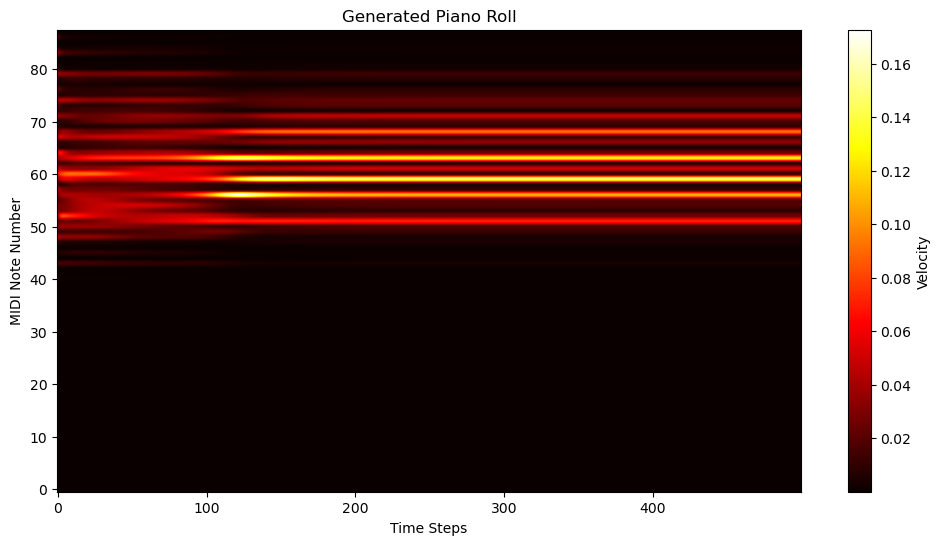

In [68]:
# Cell 2: Visualize Generated Piano Roll


def visualize_piano_roll(piano_roll, title="Generated Piano Roll"):
    """
    Visualize the piano roll as a heatmap.
    """
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll.T, aspect='auto', cmap='hot', origin='lower')
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("MIDI Note Number")
    plt.colorbar(label="Velocity")
    plt.show()

# Visualize the generated piano roll
visualize_piano_roll(generated_sequence.squeeze())


In [69]:
# Cell 3: Evaluate the Model
def evaluate_model(model, data):
    """
    Evaluate the trained VAE model on the given dataset.
    """
    # Compute reconstruction loss
    reconstruction_loss = model.vae.evaluate(
        x=[data, data],
        y=data,
        verbose=0
    )
    print(f"Reconstruction Loss: {reconstruction_loss}")
    return reconstruction_loss

# Evaluate the model on the training data
reconstruction_loss = evaluate_model(mgu_v_model, processed_data)


Reconstruction Loss: 6.355530261993408


In [70]:
from IPython.display import Audio, display

def play_midi_file(file_path):
    """
    Play a MIDI file directly in the Jupyter Notebook.
    Handles empty or invalid MIDI files gracefully.
    
    Args:
        file_path (str): Path to the MIDI file.
    Returns:
        IPython.display.Audio: An audio widget for the MIDI file, or a message if invalid.
    """
    try:
        # Load MIDI data
        midi_data = pretty_midi.PrettyMIDI(file_path)
        
        # Check for notes in all instruments
        total_notes = sum(len(instr.notes) for instr in midi_data.instruments)
        if total_notes == 0:
            raise ValueError("The MIDI file is empty or contains no notes.")

        # Synthesize audio from MIDI
        audio_data = midi_data.fluidsynth(fs=44100)  # Sampling rate: 44.1kHz

        # Return audio player
        return Audio(audio_data, rate=44100)
    
    except Exception as e:
        print(f"Error: {e}")
        print("Could not play the MIDI file. Please check the file for valid note data.")
        return None

# Path to the generated MIDI file
file_path = "/home/fariborz/courses/Research/generated_music.mid"

# Play the MIDI file
audio_widget = play_midi_file(file_path)

display(audio_widget)
